Data download from: https://www.kaggle.com/datasets/mehradaria/leukemia
Important: Install the conda environment by running the following at your commandline before running the following code:
```
conda env create -f deeplearning.yaml
conda activate deeplearning
```

### Load necessary libraries

- torch: (PyTorch) for deep learning functions
- glob: for getting file lists matching patterns
- re: for using regular expressions
- random: for random number generation (setting seed)
- PIL: (pillow) for reading and writing images
- cv2: (OpenCV) for reading and writing images, image analysis
- numpy: for manipulating, reading, and writing arrays
- matplotlib: for plotting

In [17]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import random_split
import torchvision
from torchvision import datasets, transforms
import re
import random
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
random.seed(123)
torch.manual_seed(123)

### Introduction to image data

Pillow loads image in RGB format, but PIL objects have to be converted to numpy arrays for further downstream processing.

<class 'PIL.JpegImagePlugin.JpegImageFile'>


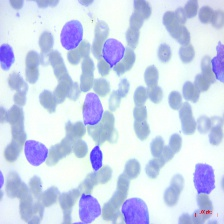

In [18]:
# Loading images with pillow
img_file = "data/Early/WBC-Malignant-Early-003.jpg"
img_pil = Image.open(img_file)
print(type(img_pil))
img_pil

OpenCV loads the image in BGR format, so it needs to be converted to RGB format for visualisation. On the plus side, the data is already a numpy array.

<class 'numpy.ndarray'>


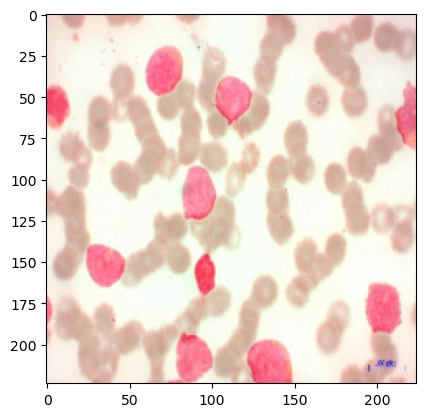

In [19]:
# Loading images with OpenCV
img_cv = cv2.imread(img_file)
print(type(img_cv))
plt.imshow(img_cv)

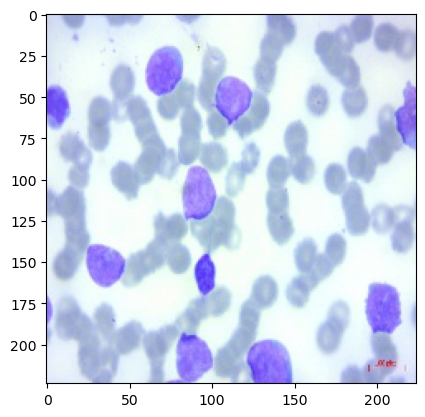

In [21]:
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
plt.imshow(img_cv)

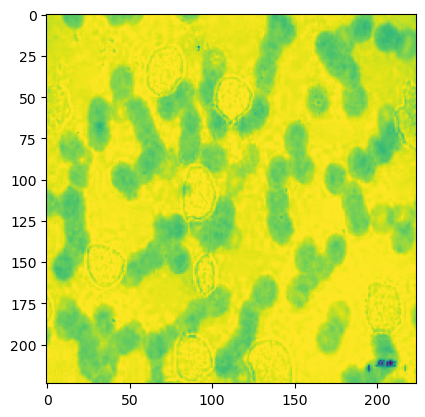

In [23]:
plt.imshow(img_cv[:, :, 2])

### Building the dataset

In [24]:
class DatasetBuilder(Dataset):
    # A class to read files from a folder, and perform necessary transformations
    # Also, the class labels are obtained from the filename
    # Also look at torchvision.transforms
    def __init__(self, folder, size=128):
        files = glob.glob(f"{folder}/*.jpg")
        # read images
        self.images = [Image.open(x) for x in files]

        # resize images
        self.images = [x.resize((128, 128), Image.Resampling.LANCZOS)  for x in self.images]

        # convert to images to numpy arrays
        self.images = [np.asarray(x) for x in self.images]

        # normalize images - try with and without normalisation
        self.images = [((x/255.0)-0.5)/0.5 for x in self.images]
        
        # get labels from filenames
        self.labels = [re.sub('.*/(.*)-(\\d+).jpg', '\\1', x) for x in files]
        self.classes_dict = dict((key, val) for val, key in enumerate(set(self.labels)))
        self.labels = [self.classes_dict[x] for x in self.labels]
        print(f"{len(self.images)} files, {len(self.labels)} labels, {len(self.classes_dict)} classes")


    def __getitem__(self, i):
        return torch.tensor(self.images[i].astype(np.float32)).permute(2, 0, 1), torch.tensor(self.labels[i])

    def __len__(self):
        return len(self.images)

    def classes(self):
        return self.classes_dict



In [25]:
# Create dataset instance
datasetfromfiles = DatasetBuilder("data/**")
dataclasses = datasetfromfiles.classes()

3256 files, 3256 labels, 4 classes


In [26]:
dataclasses

{'WBC-Malignant-Early': 0,
 'WBC-Benign': 1,
 'WBC-Malignant-Pre': 2,
 'WBC-Malignant-Pro': 3}

### Preparation for training

In [27]:
# Set batch size
batch_size = 32

# Split datasets
train_set, val_set, test_set = random_split(datasetfromfiles, [0.7, 0.15, 0.15])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5137255..1.0].


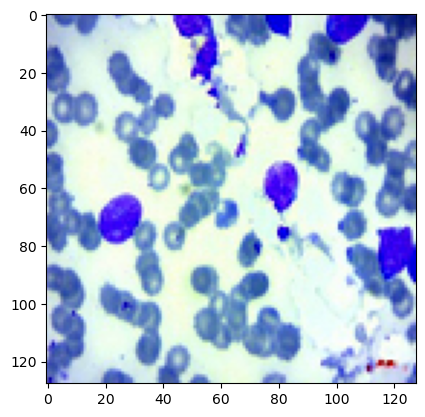

In [30]:
# Get a batch of training images
data_iter = iter(train_loader)

# Show an image to check
plt.imshow(next(data_iter)[0][0].permute(1, 2, 0))

In [31]:
next(data_iter)[0].shape

torch.Size([32, 3, 128, 128])

### What is a convolution

In [32]:
class SimpleConvModel(nn.Module):
    def __init__(self):
        super(SimpleConvModel, self).__init__()
        
        # Define a single convolution layer with 1 input channel and 1 output channel
        # kernel_size=3 applies a 3x3 filter, and stride=1 with padding=1 keeps the output size the same
        self.conv = nn.Conv2d(in_channels=3, out_channels=1, kernel_size=3, stride=1, padding=1)
        
        # Initialize the kernel (filter) manually to see specific behavior (edge detection)
        edge_kernel = torch.tensor([[[[-1, -1, -1],
                                      [-1,  8, -1],
                                      [-1, -1, -1]]]], dtype=torch.float32)
        edge_kernel = edge_kernel.repeat(1, 3, 1, 1)
        
        self.conv.weight = nn.Parameter(edge_kernel)

    def forward(self, x):
        x = self.conv(x)
        return x


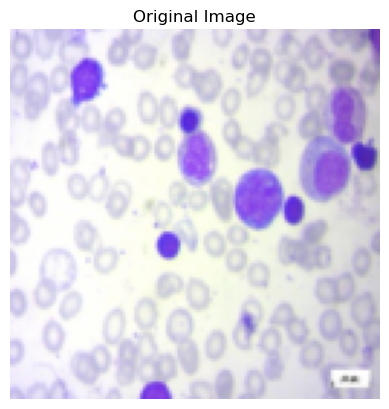

In [33]:
# Load a grayscale image and apply transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),    # Resize for easier visualization
    transforms.ToTensor()             # Convert image to tensor [1, H, W]
])

image = Image.open("data/Benign/WBC-Benign-004.jpg")
image = transform(image).unsqueeze(0)  # Add batch dimension to shape [1, 1, H, W]

# Plot the original image
plt.imshow(image.squeeze().permute(1, 2, 0))#, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()


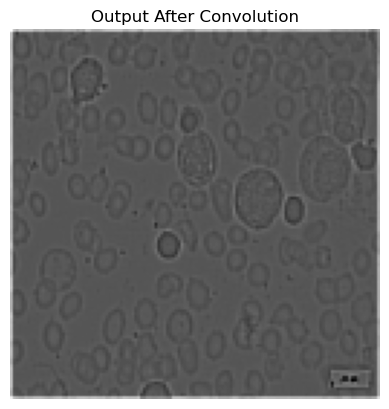

In [34]:
# Initialize the model and move it to evaluation mode
model = SimpleConvModel()
model.eval()

# Apply the model to the image
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(image)

# Convert output tensor to numpy for plotting
output_image = output.squeeze().numpy()

# Plot the output after convolution
plt.imshow(output_image, cmap="gray")
plt.title("Output After Convolution")
plt.axis("off")
plt.show()


In SimpleConvModel, try changing the edge kernel to the following:
```
edge_kernel = torch.tensor([[[[1, 1, 1],
                              [0, 0, 0],
                              [-1, -1, -1]]]], dtype=torch.float32)

```

### Now to build a Convolutional Neural Network model

In [35]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Pooling layer

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust dimensions based on image size after convolutions
        self.fc2 = nn.Linear(128, num_classes)    # Output layer for the number of classes

    def forward(self, x):
        # Pass through first convolutional layer, apply activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        
        # Pass through second convolutional layer, apply activation and pooling
        x = self.pool(F.relu(self.conv2(x)))
        
        # Pass through third convolutional layer, apply activation and pooling
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor for fully connected layers
        x = x.view(-1, 64 * 16 * 16)  # Flattening

        # Pass through first fully connected layer
        x = F.relu(self.fc1(x))
        
        # Output layer (no activation, as we'll apply CrossEntropyLoss during training)
        x = self.fc2(x)
        
        return x

In [36]:
# Define the number of classes based on our dataset
num_classes = len(dataclasses) 

# Initialize the model
model = SimpleCNN(num_classes=num_classes)


In [37]:

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001) 


In [38]:
# training loop
num_epochs = 10  # Set number of epochs for training; change this number to see how model works

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:  
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")


Epoch [1/10], Loss: 0.7861
Epoch [2/10], Loss: 0.4159
Epoch [3/10], Loss: 0.3218
Epoch [4/10], Loss: 0.2534
Epoch [5/10], Loss: 0.1991
Epoch [6/10], Loss: 0.1390
Epoch [7/10], Loss: 0.0919
Epoch [8/10], Loss: 0.0715
Epoch [9/10], Loss: 0.0489
Epoch [10/10], Loss: 0.0345
Training complete!


In [39]:
# Model evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:  
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')


Validation Accuracy: 90.78%


### Exercise
- Exercise - try adding conv layers and see the effect on model performance
- Hyperparameter tuning - learning rate

### Using pre-trained models (e.g. ResNet18)

In [40]:
from torchvision.models import resnet18, ResNet18_Weights

In [41]:
from torchvision.io import decode_image, read_image

In [42]:
# Initialize model with the available weights
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in train_loader:  
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')


Validation Accuracy: 0.00%


### Why is the accuracy zero?
Let's look at one image

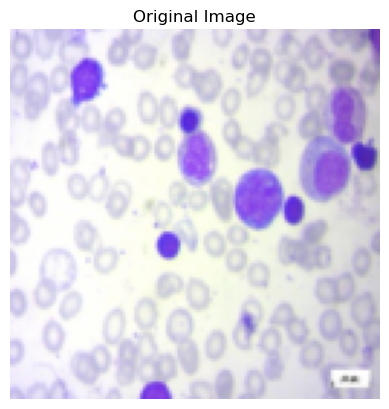

In [45]:
# Load an image and apply transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),    # Resize for easier visualization
    transforms.ToTensor()             # Convert image to tensor [1, H, W]
])

image = Image.open("data/Benign/WBC-Benign-004.jpg")
image = transform(image).unsqueeze(0)  # Add batch dimension to shape [1, 1, H, W]

# Plot the original image
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.title("Original Image")
plt.axis("off")
plt.show()

In [46]:
# Initialize the ResNet model and move it to evaluation mode
model.eval()

# Apply the model to the image
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(image)
    _, predicted = torch.max(output, 1)
print(predicted.item())

import urllib.request
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
class_labels = urllib.request.urlopen(url).read().decode().splitlines()

class_labels[predicted.item()]

794


'shower curtain'

### Re-training a model - using the same weights, but assigning different classes

In [47]:
# Create dataset instance
datasetfromfiles = DatasetBuilder("data/**", size=224)
dataclasses = datasetfromfiles.classes()
dataclasses

3256 files, 3256 labels, 4 classes


{'WBC-Malignant-Early': 0,
 'WBC-Benign': 1,
 'WBC-Malignant-Pre': 2,
 'WBC-Malignant-Pro': 3}

In [48]:
# Freeze all layers except the final layer (optional, for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer with a new one
num_classes = len(dataclasses)  # Number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)


In [49]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer, only updating the final layer
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [50]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Move data to device if using GPU
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')
        model.train()  # Set model back to training mode after validation

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)


Epoch 1/5, Loss: 0.7428912756343683
Validation Accuracy: 90.37%
Epoch 2/5, Loss: 0.3159625944164064
Validation Accuracy: 93.44%
Epoch 3/5, Loss: 0.2295222199625439
Validation Accuracy: 94.67%
Epoch 4/5, Loss: 0.19898706291698748
Validation Accuracy: 95.29%
Epoch 5/5, Loss: 0.1657128652764691
Validation Accuracy: 95.90%


In [51]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:  
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

Validation Accuracy: 92.83%


In [ ]:
dataclasses

In [52]:
# Initialize the ResNet model and move it to evaluation mode
model.eval()

# Apply the model to the image
with torch.no_grad():  # Disable gradient calculation for inference
    output = model(image)
    _, predicted = torch.max(output, 1)
print(predicted.item())

class_labels = {v: k for k,v in dataclasses.items()}

class_labels[predicted.item()]

1


'WBC-Benign'